In [1]:
import pandas as pd
import string
import nltk
import numpy as np
import sklearn
import seaborn as sns
import re
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from scipy.sparse import hstack
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Load Dataset**

In [0]:
train_data=pd.read_csv("/content/drive/My Drive/ML project'20/YelpZip/train_newb.csv")
val_data=pd.read_csv("/content/drive/My Drive/ML project'20/YelpZip/val_newb.csv")
test_data=pd.read_csv("/content/drive/My Drive/ML project'20/YelpZip/test_newb.csv")

In [5]:
train_data.head()

,user_id,product_id,rating,label,date,review_text,day,year,word_count,punctuation_count,char_count,title_count,user_id_no_of_review,user_id_ave_rating,user_id_ave_no_words,user_id_max_review_a_day,product_id_no_of_review,product_id_ave_rating,product_id_ave_no_of_words,product_id_max_review_a_day
0,192117,3237,4.0,-1,2012-12-30,"delish! pizza was huge, flavorful and filling!...",Sunday,2012,52,8,296,7,1,4.0,52.0,1,114,4.017544,74.684211,14
1,83124,2122,4.0,1,2012-01-21,lava's hummus is better than zahav's. there. i...,Saturday,2012,225,34,1233,21,1,4.0,225.0,1,15,3.666667,140.266667,3
2,137167,3222,2.0,1,2012-08-10,my friend and i decided to come check this pla...,Friday,2012,247,21,1315,11,1,2.0,247.0,1,32,3.500000,82.656250,4
3,51095,523,3.0,1,2012-04-23,oy vey. i really really wanted to write a good...,Monday,2012,210,52,1184,22,1,3.0,210.0,1,18,3.111111,107.611111,6
4,194284,2605,4.0,-1,2012-03-22,i heard about the wait and it was worth it. th...,Thursday,2012,21,4,95,2,2,3.5,25.5,2,117,3.837607,124.427350,15


In [0]:
X_train=train_data.drop(['user_id','product_id','year','date','label','rating'],axis=1)
y_train=train_data.label
X_test=test_data.drop(['user_id','product_id','year','date','label'],axis=1)
y_test=test_data.label
X_valid=val_data.drop(['user_id','product_id','year','date','label'],axis=1)
y_valid=val_data.label

In [0]:
pd.set_option('mode.chained_assignment', None)

 **Text Preprocessing**

In [0]:
#Function for expanding all the contractions in the paragraph
with open("/content/drive/My Drive/ML project'20/Contractions.json",'r') as file:
   Contractions=json.load(file)
c_re = re.compile('(%s)' % '|'.join(Contractions.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return Contractions[match.group(0)]
    return c_re.sub(replace, text)

In [0]:
# lowercase,remove digits,punctuations,expand contractions,stopwords and lemmatization
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
X_train['review_text']=X_train['review_text'].apply(lambda x : ''.join([c for c in x if not c.isdigit()])) #Remove numeric digits
X_train['review_text']=X_train['review_text'].apply(lambda x:  ''.join([c for c in x if c not in string.punctuation]))  # Remove punctuations
X_train['review_text']=X_train['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
X_train['review_text']=X_train['review_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

#Val Dataset
X_valid['review_text']=X_valid['review_text'].apply(lambda x : ''.join([c for c in x if not c.isdigit()])) #Remove numeric digits
X_valid['review_text']=X_valid['review_text'].apply(lambda x:  ''.join([c for c in x if c not in string.punctuation]))  # Remove punctuations
X_valid['review_text']=X_valid['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
X_valid['review_text']=X_valid['review_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

# Test Dataset
X_test['review_text']=X_test['review_text'].apply(lambda x : ''.join([c for c in x if not c.isdigit()])) #Remove numeric digits
X_test['review_text']=X_test['review_text'].apply(lambda x:  ''.join([c for c in x if c not in string.punctuation]))  # Remove punctuations
X_test['review_text']=X_test['review_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))
X_test['review_text']=X_test['review_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

## Model

### Classification on review text + features

In [10]:
# Count vectorizer for review_text
count_vect=CountVectorizer(analyzer='word')
count_vect.fit(X_train.review_text)
feature_vector_train=count_vect.transform(X_train.review_text)
feature_vector_test =count_vect.transform(X_test.review_text)
feature_vector_valid =count_vect.transform(X_valid.review_text)

#Count Vectorizer for day
count_vect_=CountVectorizer(analyzer='word')
count_vect_.fit(X_train.day)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
# Count vectors + Features
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_no_of_review"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_ave_rating"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_ave_no_words"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["user_id_max_review_a_day"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_no_of_review"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_ave_rating"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_ave_no_of_words"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["product_id_max_review_a_day"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["word_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["punctuation_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["char_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,np.array(X_train["title_count"])[:,None]))
feature_vector_train=hstack((feature_vector_train,count_vect_.transform(X_train["day"])))

feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["user_id_no_of_review"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["user_id_ave_rating"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["user_id_ave_no_words"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["user_id_max_review_a_day"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["product_id_no_of_review"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["product_id_ave_rating"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["product_id_ave_no_of_words"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["product_id_max_review_a_day"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["word_count"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["punctuation_count"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["char_count"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,np.array(X_valid["title_count"])[:,None]))
feature_vector_valid=hstack((feature_vector_valid,count_vect_.transform(X_valid["day"])))


feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_no_of_review"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_ave_rating"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_ave_no_words"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["user_id_max_review_a_day"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_no_of_review"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_ave_rating"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_ave_no_of_words"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["product_id_max_review_a_day"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["word_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["punctuation_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["char_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,np.array(X_test["title_count"])[:,None]))
feature_vector_test=hstack((feature_vector_test,count_vect_.transform(X_test["day"])))

In [12]:
LR= LogisticRegression()
LR.fit(feature_vector_train,y_train)
predictions_train=LR.predict(feature_vector_train)
y_test_pred=LR.predict(feature_vector_test)
y_val_pred=LR.predict(feature_vector_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [13]:
feature_vector_test

<10000x44414 sparse matrix of type '<class 'numpy.float64'>'
	with 542763 stored elements in COOrdinate format>

In [14]:
print('\033[1m'+"Train Dataset Report:\n"+'\033[0m')
print(classification_report(y_train,predictions_train))
print('\033[1m'+"Validation Dataset Report:\n"+'\033[0m')
print(classification_report(y_valid,y_val_pred))
print('\033[1m'+"Test Dataset Report:\n"+'\033[0m')
print(classification_report(y_test,y_test_pred))

Train Dataset Report:

              precision    recall  f1-score   support

          -1       0.63      0.73      0.68     12500
           1       0.68      0.58      0.62     12500

    accuracy                           0.65     25000
   macro avg       0.66      0.65      0.65     25000
weighted avg       0.66      0.65      0.65     25000

Validation Dataset Report:

              precision    recall  f1-score   support

          -1       0.58      0.82      0.68      2500
           1       0.69      0.40      0.51      2500

    accuracy                           0.61      5000
   macro avg       0.63      0.61      0.59      5000
weighted avg       0.63      0.61      0.59      5000

Test Dataset Report:

              precision    recall  f1-score   support

          -1       0.59      0.79      0.68      5000
           1       0.68      0.45      0.55      5000

    accuracy                           0.62     10000
   macro avg       0.64      0.62      0.61     10000
w

In [21]:
print("Accuracy of LR on train dataset : {ac: .2f}%".format(ac=accuracy_score(y_train,predictions_train)*100))
print("Accuracy of LR on valid dataset : {ac: .2f}%".format(ac=accuracy_score(y_valid,y_val_pred)*100))
print("Accuracy of LR on test dataset  : {ac: .2f}%".format(ac=accuracy_score(y_test,y_test_pred)*100))

Accuracy of LR on train dataset :  65.38%
Accuracy of LR on valid dataset :  60.98%
Accuracy of LR on test dataset  :  62.10%


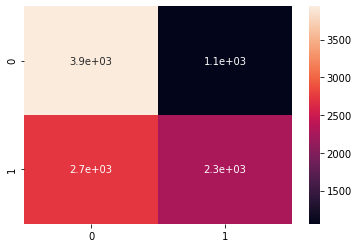

In [23]:
cm=confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True)

### Classification on review text

In [24]:
count_vect=CountVectorizer(analyzer='word')
count_vect.fit(X_train.review_text)
X_train_count=count_vect.transform(X_train.review_text)
X_test_count =count_vect.transform(X_test.review_text)
X_valid_count =count_vect.transform(X_valid.review_text)
LR= LogisticRegression()
LR.fit(X_train_count,y_train)
predictions_train=LR.predict(X_train_count)
predictions_test=LR.predict(X_test_count)
predictions_valid=LR.predict(X_valid_count)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
print('\033[1m'+"Train Dataset Report:\n"+'\033[0m')
print(classification_report(y_train,predictions_train))
print('\033[1m'+"Validation Dataset Report:\n"+'\033[0m')
print(classification_report(y_valid,predictions_valid))
print('\033[1m'+"Test Dataset Report:\n"+'\033[0m')
print(classification_report(y_test,predictions_test))

Train Dataset Report:

              precision    recall  f1-score   support

          -1       0.85      0.92      0.88     12500
           1       0.91      0.83      0.87     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Validation Dataset Report:

              precision    recall  f1-score   support

          -1       0.61      0.68      0.65      2500
           1       0.64      0.57      0.60      2500

    accuracy                           0.62      5000
   macro avg       0.63      0.62      0.62      5000
weighted avg       0.63      0.62      0.62      5000

Test Dataset Report:

              precision    recall  f1-score   support

          -1       0.63      0.71      0.67      5000
           1       0.67      0.58      0.62      5000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
w

In [26]:
print("Accuracy of LR on train dataset : {ac: .2f}%".format(ac=accuracy_score(y_train,predictions_train)*100))
print("Accuracy of LR on valid dataset : {ac: .2f}%".format(ac=accuracy_score(y_valid,y_val_pred)*100))
print("Accuracy of LR on test dataset  : {ac: .2f}%".format(ac=accuracy_score(y_test,y_test_pred)*100))

Accuracy of LR on train dataset :  87.62%
Accuracy of LR on valid dataset :  60.98%
Accuracy of LR on test dataset  :  62.10%


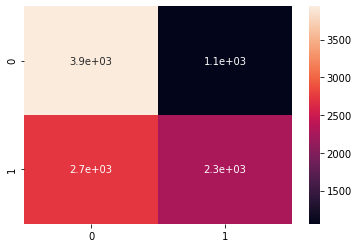

In [27]:
cm=confusion_matrix(y_test,y_test_pred)
sns.heatmap(cm,annot=True)